In [1]:
from nltk.tokenize import sent_tokenize
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import glob
import os
import string
import numpy
import re
import pandas as pd
import multiprocessing
import gensim
import random
from tqdm import tqdm
from gensim.models import KeyedVectors
from adjustText import adjust_text
from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
from scipy.cluster.vq import kmeans,vq
import numpy as np
import matplotlib.pyplot as plt


C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
os.chdir("C://Users//Ruben//Documents//GitHub//TheForeign//SCC//output-data")

In [35]:
#df['ngram'] = df['ngram'].str.split().str[0]

In [3]:
list_models = glob.glob('*.bin')
model = KeyedVectors.load_word2vec_format(list_models[0], binary = True)
df = pd.read_csv('bigrams_buitenlandsche.csv')

In [4]:
df.columns = ["ngram"] + [str(y) for y in range(1815,1915)]

In [7]:
df = df[df.ngram != 'zaken']

In [8]:
def MatrixPeriod(start_year, interval, freq_threshold, df):
    
    df = pd.melt(df, id_vars=['ngram'])
    df['variable'] = df['variable'].astype(int)
    df = df[df['variable'] >= start_year]
    df = df[df['variable'] < start_year + interval]
    df['variable'] = 'tot_count'
    df = df.groupby(['ngram']).sum()
    
    list_words = list(df[df['value'] > freq_threshold].index)
    
    
    dmx = DistanceMatrix(list_words, model)
    
    return dmx

def DistanceMatrix(list_words, model):
    
    list_words = [w for w in list_words if w in list(model.vocab)]
    print("created list with " + str(len(list_words)) + " words")

    total_list = list()
    
    for word in list_words:
        
        list_word = list()
        
        for term in list_words:
            #tmp = model.distance(word, term)
            tmp = model.similarity(word, term)

            list_word.append(tmp)
        
        total_list.append(list_word)
    df = pd.DataFrame(total_list, columns = list_words, index = list_words)
    return df

def ClusterWord(matrix, k):
    centroids,_ = kmeans(matrix,k)
    idx,_ = vq(matrix,centroids)
    
    return dict(zip(list(matrix.index), idx))


def GetClusterNames(clus_dict, df, start_year, interval):
    start_column = list(df.columns).index(str(start_year))
    df = df.iloc[:,np.r_[0,start_column:start_column+interval]]
    
    df = df[df.ngram.isin([k for k,v in clus_dict.items()])]
    
    dict_topwords_cluster = dict()
    
    for cluster_id in list(set([v for k,v in clus_dict.items()])):
        list_words_cluster = [k for k,v in clus_dict.items() if v == cluster_id]
        
        tmpdf = df[df.ngram.isin(list_words_cluster)]
        tmpdf['word_sum'] = tmpdf.iloc[:,1:len(tmpdf.columns)].sum(axis=1)
        
        topwords = list(tmpdf.nlargest(6,'word_sum').ngram)
        topwords = " | ".join(topwords)
        dict_topwords_cluster.update({str(cluster_id):topwords})
        
        
    return dict_topwords_cluster

def ClusterDf(clus_dict, df, start_year, interval, dict_topwords_cluster):
    start_column = list(df.columns).index(str(start_year))
    df = df.iloc[:,np.r_[0,start_column:start_column+interval]]
    
    df = df[df.ngram.isin([k for k,v in clus_dict.items()])]
    
    cluster_sums_dict = dict()
    
    # Calculate Diachronic Sums of Clusters
    for cluster_id in list(set([v for k,v in clus_dict.items()])):
        list_words_cluster = [k for k,v in clus_dict.items() if v == cluster_id]
        
        tmpdf = df[df.ngram.isin(list_words_cluster)]
        
        tmpdf_sums = list(tmpdf.iloc[:,1:len(tmpdf.columns)].sum(axis=0))
        
        cluster_sums_dict.update({cluster_id:tmpdf_sums})
        
    cluster_sums = pd.DataFrame.from_dict(cluster_sums_dict)
    cluster_sums['year'] = list(range(start_year,start_year+interval))
    cluster_sums.columns = cluster_sums.columns.astype(str)
    
    cluster_sums['sum'] = cluster_sums.iloc[:,0:len(cluster_sums.columns)-1].sum(axis=1)
    
    for column in list(cluster_sums.columns)[0:len(cluster_sums.columns)-2]:
        cluster_sums[column] = cluster_sums[column] / cluster_sums['sum'] * 100
    
    range_years = [str(y) for y in list(cluster_sums.columns)[0:len(cluster_sums.columns)-2]]
    
    ### Set top words as labels
    cluster_sums.columns = list([v for k,v in dict_topwords_cluster.items()]) + ['year', 'sum']    
    cluster_sums['year'] = cluster_sums['year'].astype(str)
    cluster_sums.plot(x="year", y = list([v for k,v in dict_topwords_cluster.items()]), kind="area", colormap = "tab20b", figsize=(16,6)).legend(bbox_to_anchor=(1, 1))
    return cluster_sums



In [9]:
def MasterFunction(start_year, interval, freq_threshold, k,df):
    mdf = MatrixPeriod(start_year, interval, freq_threshold,df)
    clus_dict = ClusterWord(mdf,k)
    dict_topwords_cluster = GetClusterNames(clus_dict, df, start_year, interval)
    t = ClusterDf(clus_dict, df,start_year,interval,dict_topwords_cluster)
    
    op = [clus_dict, dict_topwords_cluster, t]
    return op

In [41]:
os.chdir("D://Scriptie//Data//models//10yp_s150")
list_mod = glob.glob('*bin')
list_mod

['1815_w150_10yp_model.bin',
 '1825_w150_10yp_model.bin',
 '1905_w150_10yp_model.bin',
 '1895_w150_10yp_model.bin',
 '1885_w150_10yp_model.bin',
 '1875_w150_10yp_model.bin',
 '1865_w150_10yp_model.bin',
 '1855_w150_10yp_model.bin',
 '1845_w150_10yp_model.bin',
 '1835_w150_10yp_model.bin']

created list with 522 words


C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[{'00': 4,
  '11': 4,
  '14': 4,
  '1867': 4,
  '1871': 4,
  '1894': 4,
  '1»': 4,
  '31': 4,
  '312': 4,
  '70': 4,
  '87': 4,
  'aan': 10,
  'aanbiedingen': 9,
  'aandeelen': 1,
  'aandeelhouders': 0,
  'aangeboden': 4,
  'aangelegenheden': 11,
  'aankoopen': 9,
  'aannemers': 0,
  'aanvoeren': 7,
  'academie': 2,
  'afdeeling': 0,
  'afdeelingen': 0,
  'afgevaardigden': 2,
  'afkomst': 2,
  'afnemers': 6,
  'agenten': 1,
  'aken': 3,
  'algemeen': 10,
  'als': 10,
  'ambtenaren': 2,
  'anarchisten': 2,
  'arbeiders': 0,
  'arbitrage': 11,
  'archieven': 2,
  'architecten': 0,
  'artikelen': 9,
  'artisten': 2,
  'artsen': 2,
  'auteurs': 2,
  'autoriteiten': 2,
  'a°': 4,
  'bank': 1,
  'bankbiljetten': 1,
  'banken': 1,
  'bankiers': 1,
  'behoefte': 5,
  'belangen': 11,
  'belanghebbenden': 0,
  'belangstelling': 2,
  'beleid': 10,
  'belrekkingen': 11,
  'berichten': 3,
  'berigien': 3,
  'berigten': 3,
  'bestond': 10,
  'betrekkingen': 11,
  'beursberigten': 3,
  'beurzen': 9,


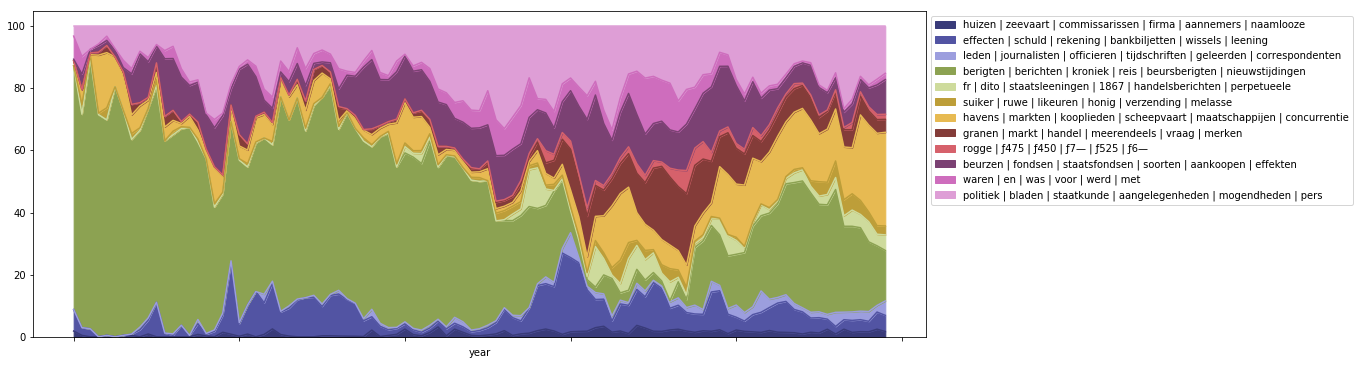

In [11]:
MasterFunction(1815, 99, 10, 12,df)

created list with 103 words


C:\ProgramData\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


created list with 268 words
created list with 409 words


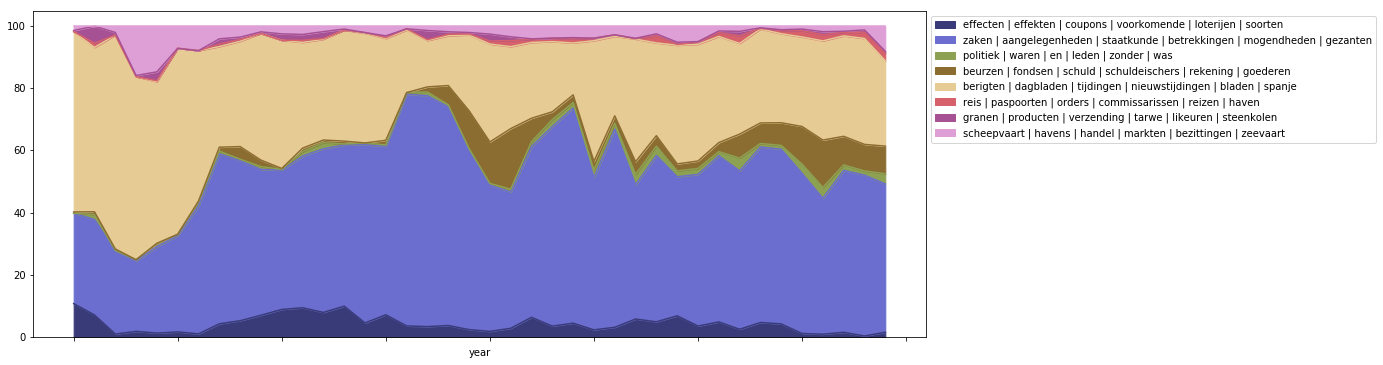

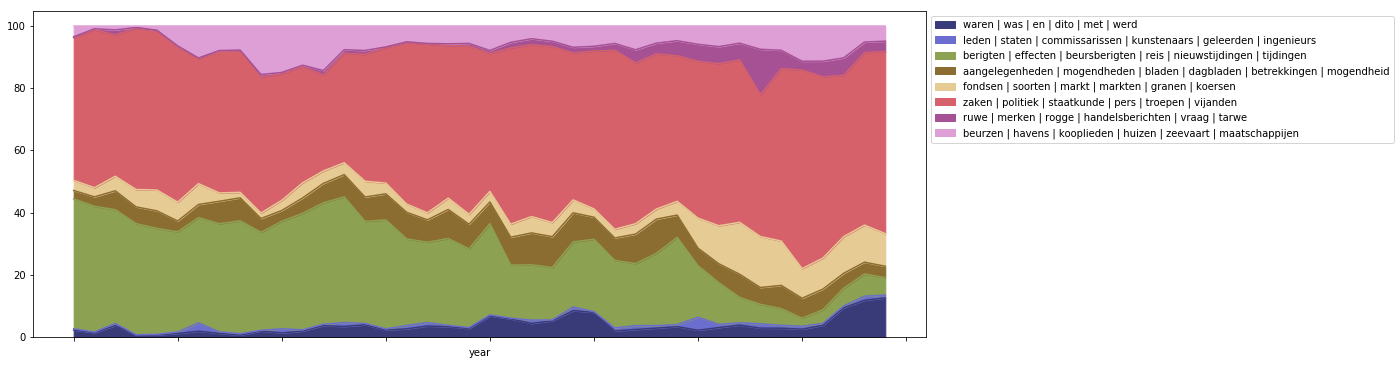

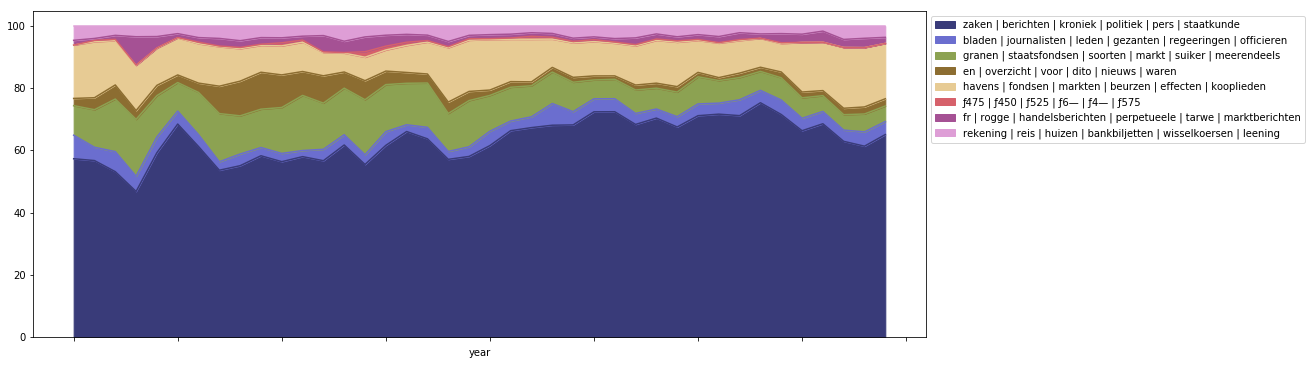

In [46]:
os.chdir("C://Users//Ruben//Documents//GitHub//TheForeign//Visualizations//CH1//source-files")
os.chdir("D://Scriptie//Data//models//10yp_s150")

for k in [1815,1845,1875]:
    m = [i for i in list_mod if int(i[0:4]) == k][0]
    model = KeyedVectors.load_word2vec_format(m, binary = True)
    d = MasterFunction(k, 40, 10, 8,df)
    #dt = d[2]
    #fn = "buitenlandsche_clusters_period2_" + str(k) + ".csv"
    #dt.to_csv(fn, index=False)

In [16]:
list_ec = [k for k,v in d[0].items() if v == 6 or v == 3 or v == 4 or v == 9]

In [19]:
df = df[df.ngram.isin(list_ec)]

In [24]:
cl = df.columns[1:]

In [26]:
df['sum'] = df[cl].sum(axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
df.iloc[:,:30]

,ngram,1815,1816,1817,1818,1819,1820,1821,1822,1823,...,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843
348,beurzen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,217.0,280.0,71.0,0.0,2.0,0.0,0.0,0.0,2.0
359,bezittingen,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,2.0,11.0,3.0,5.0,13.0,0.0
462,concurrentie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487,coupons,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565,effecten,26.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,31.0,28.0,42.0,75.0,44.0,74.0,31.0,56.0,83.0,84.0
567,effekten,0.0,19.0,4.0,9.0,7.0,8.0,6.0,37.0,39.0,...,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
639,fabrijken,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,4.0,3.0,0.0,2.0
672,fondfen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,fondsen,2.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,32.0,...,36.0,16.0,11.0,7.0,16.0,19.0,15.0,34.0,46.0,46.0
722,geldleening,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
